# Tutorial de LSTM

En este tutorial aplicaremos una red recurrente tipo LSTM a una serie de precios. Este tutorial se enfoca a generar una estructura tal en los datos que permita un pronóstico hacia adelante. Es decir, buscamos generar una red neuronal a un conjunto de datos condicionados a eventos pasados, para luego generar un pronóstico futuro de los mismos. La serie por tanto genera una red entrenada en una sección de entrenamiento y prueba, como es común, para luego generar un pronóstico hacia adelante en una estructura de datos transformada. Es decir, esta estructura de datos contempla un conjunto de datos como entrada y una salida de manera anticipada que pueda ser empleada por el modelo supervisado.

Algunas paqueterías en Python generan esta estructura mediante una función llamada TimeSeriesGenerator, lo cual puede ser un tanto retador si se hace de manera manual. La libreria de keras de deep learning provee esta función la cual, transforma series univariadas y multivariadas en este tipo de estructuras antes de poder aplicar el modelo y generar el pronóstico hacia adelante.

**Contenido**
1. [Importación de librerías requeridas](#2)
1. [Importación de datos financieros](#3)
1. [Visualización de datos financieros](#4)
1. [Preprocesamiento de datos](#5)
1. [Partición de datos en entrenamiento y prueba](#6)
1. [Definición de la estructura de datos transformada](#7)
1. [Diseño y entrenamiento de la red neuronal](#8)
1. [Incrustación del modelo en la estructura de datos para pronóstico de prueba](#9)
1. [Generación del pronóstico hacia adelante](#10)
1. [Visualización del pronóstico hacia adelante](#11)


Este tutorial fue adaptado del de Predicting Sequential Data using LSTM: An Introduction.

In [1]:
!pip install yfinance --upgrade --no-cache-dir
!pip install pandas-datareader --upgrade --no-cache-dir


In [33]:
#import
import tensorflow as tf

#univariate one step problem with lstm
from numpy import array
from tensorflow.keras.models import Sequential # Import from tensorflow.keras
from tensorflow.keras.layers import Dense,  LSTM # Import from tensorflow.keras
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator # Import from tensorflow.keras

#Estas son paqueterías complementarias para la descarga de datos financieros
import pandas as pd
from pandas_datareader import data as pdr
import yfinance as yf

#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

#Plots
import matplotlib.pyplot as plt
import plotly.graph_objects as go

<a id="2"></a> <br>
### 1. Importación de librerías requeridas

Importa las siguientes librerías para desarrollar este tutorial:

In [3]:
#Esta es requerida para importar los datos financieros
#!pip install yfinance

In [34]:
#Estas son paqueterías complementarias para la descarga de datos financieros
import pandas
from pandas_datareader import data as pdr
import yfinance as yfin
#yfin.pdr_override()
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

In [6]:
##Si tienes problemas para descarlar pandas datareader, puedes probar la siguiente linea:
#!pip install git+https://github.com/pydata/pandas-datareader.git

<a id="3"></a> <br>
### 2. Importación de datos financieros

Establecemos primeramente la fehca de inicio y fin, así como el activo o los activos de interés. En este ejemplo, emplearemos únicamente un activo, pero dejo desactivados otros ejemplos de stocks (stks), índices (idx), monedas (ccy) como ejemplos de otros activos.

In [35]:
#Establecemos las fechas de consulta:
start = '2015-01-01'
end = '2022-07-29'
#ticker = 'AAPL'
#data = pdr.get_data_yahoo(ticker, start, end)['Adj Close']
amzn='AAPL'

In [36]:
#una vez declarado el ticker, pedimos a través de la función de pandas data reader (pdr), bajar lso datos de la fuente de yahoo finance.
amzn = yf.download("AMZN", start, end)['Close']

[*********************100%***********************]  1 of 1 completed


In [37]:
amzn.head()

Ticker,AMZN
Date,
2015-01-02,15.4260
2015-01-05,15.1095
2015-01-06,14.7645
2015-01-07,14.9210
2015-01-08,15.0230


In [38]:
import pandas
#pasamos a data frame los datos
dt= pandas.DataFrame(amzn)
dt.head()

Ticker,AMZN
Date,
2015-01-02,15.4260
2015-01-05,15.1095
2015-01-06,14.7645
2015-01-07,14.9210
2015-01-08,15.0230


In [39]:
#Identificamos la longitud de la serie
len(dt)

1906

In [40]:
#Damos un vistazo a los datos
dt.head()
dt.tail()

Ticker,AMZN
Date,
2022-07-22,122.419998
2022-07-25,121.139999
2022-07-26,114.809998
2022-07-27,120.970001
2022-07-28,122.279999


<a id="4"></a> <br>
### 3. Visualización de datos financieros

Podemos mirar la serie, debems importar la librería de matplotlib.

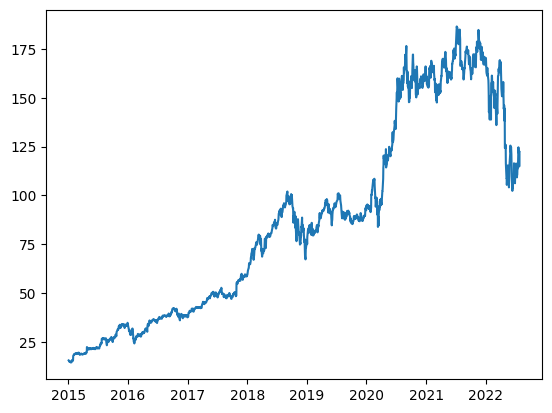

In [41]:
#Una vez llamada la librería, graficamos la serie dt.
import matplotlib.pyplot as plt
plt.plot(dt)

<a id="5"></a> <br>
### 4. Preprocesamiento de datos

En esta parte, debemos primero convertir nuestros datos tipo dataframe, a un objeto de pandas con fecha. Igualmente, la parte de valores de la serie, como el precio, lo pasamos a un tipo NumPy array que facilitará el procesamiento.

dt['date'] = pd.to_datetime(dt.index)
dt.head()

In [42]:
#Ahora, pasamos el data frame a un objeto de tiempo de pandas.
dataindex= pd.to_datetime(dt.index)
dataindex

DatetimeIndex(['2015-01-02', '2015-01-05', '2015-01-06', '2015-01-07',
               '2015-01-08', '2015-01-09', '2015-01-12', '2015-01-13',
               '2015-01-14', '2015-01-15',
               ...
               '2022-07-15', '2022-07-18', '2022-07-19', '2022-07-20',
               '2022-07-21', '2022-07-22', '2022-07-25', '2022-07-26',
               '2022-07-27', '2022-07-28'],
              dtype='datetime64[ns]', name='Date', length=1906, freq=None)

In [43]:
#Ahora, a numpy array:
dt2= amzn.to_numpy()
dt2

array([[ 15.42599964],
       [ 15.10949993],
       [ 14.76449966],
       ...,
       [114.80999756],
       [120.97000122],
       [122.27999878]])

In [44]:
#Y generamos un rearreglo de la dimensión del array a 1D, en los renglones (el -1 signigica que numpy calcula este número por nosotros).
close_data = dt2.reshape((-1,1))
close_data

array([[ 15.42599964],
       [ 15.10949993],
       [ 14.76449966],
       ...,
       [114.80999756],
       [120.97000122],
       [122.27999878]])

<a id="6"></a> <br>
### 5. Partición de datos en entrenamiento y prueba

En esta seción, partimos el conjunto de datos de pueba y de entrenamiento. Podemos tomar una referencia general de una proporción del 80/20 de la serie.

In [45]:
#Especificamos primeramente el porcentje del corte.
split_percent = 0.90
split = int(split_percent*len(close_data))

#Aplicamos dicha proporción a la definición de la parte de entrenamiento y de prueba.
close_train = close_data[:split]
close_test = close_data[split:]

date_train = dataindex[:split]
date_test = dataindex[split:]

In [46]:
date_train

DatetimeIndex(['2015-01-02', '2015-01-05', '2015-01-06', '2015-01-07',
               '2015-01-08', '2015-01-09', '2015-01-12', '2015-01-13',
               '2015-01-14', '2015-01-15',
               ...
               '2021-10-11', '2021-10-12', '2021-10-13', '2021-10-14',
               '2021-10-15', '2021-10-18', '2021-10-19', '2021-10-20',
               '2021-10-21', '2021-10-22'],
              dtype='datetime64[ns]', name='Date', length=1715, freq=None)

In [48]:
#imprimimos la longitud de ambos conjuntos de datos:
print(len(close_train))
print(len(close_test))

1715
191


<a id="7"></a> <br>
### 6. Definición de la estructura de datos transformada

En esta seción, generamos la estructura de datos transformada para poder ser empleada en un model supervisado, incluyendo una red neuronal. Básicamente se trata de dar una estructura a partir de una ventana histórica de la serie, que siendo una serie financiera, esta ventana debiera ser la más reciente. Imaginarse que tenemos una serie como la siguiente:

[9,10,11,12,13,14,15,16,17]

Si estamos interesados en generar predicciones a un paso, las observaciones previas, llamadas, lags se emplean como entrada y la salida es la observación actual. Por ejemplo, la serie anterior de 9 pasos se puede expresar como un porblema de aprendizaje supervisado con tres time-steps como entrada y una de salida:

* [9,10,11] -> [12]
* [10,11,12]-> [13]
* [11,12,13]-> [14]
* [12,13,14]-> [15]
* [13,14,15]-> [16]
* [14,15,16]-> [17]


Para generar una estructura tal, existe un módulo en Keras llamado TimeseriesGenerator. Esta función embebe los datos dentro de esta función, generando un objeto que servirá de alimento a la red neuronal. Así, generamos primero los features en la serie.

In [49]:
#Especificamos la longitud o length, es el número de observaciones tipo lags a emplear en la prción de entrada de cada muestra, el ejemplo anterior era de 3.
#batch size representa en número de sub-series o muestras a generar en cada lote. En este caso, pueden ser uno o más. Por ejemplo, en la imagen anterior, el batch size es de 3.
n_back = 15   #la longitud
train_generator = TimeseriesGenerator(close_train, close_train, length=n_back, batch_size=25)
test_generator = TimeseriesGenerator(close_test, close_test, length=n_back, batch_size=1)

In [50]:
# Podemos ver el número de muestras que se prepararán en los datos por el generador para esta serie
print('Samples: %d' % len(train_generator))
print('Samples: %d' % len(test_generator))


Samples: 68
Samples: 176


In [22]:
#Podríamos imprimir  los componentes de entrada
#for i in range(len(train_generator)):
#	x, y = train_generator[i]
#	print('%s => %s' % (x, y))

<a id="8"></a> <br>
### 7. Diseño y entrenamiento de la red neuronal

En esta sección generamos primero el diseño de la red y la entrenamos acorde el número de epochs definidos y demás parámetros.

In [51]:
##Neural Net
#Importamos primero los módulos requeridos:
from keras.models import Sequential
from keras.layers import LSTM, Dense

#Configuramos la de red.
model = Sequential()
model.add(
    LSTM(200,  ## de nodos, dependerá de su poder de cómputo.
        activation='relu',
        input_shape=(n_back,1))   ##la longitud de la secuencia
)
model.add(Dense(1))  #capa de salida de predicción
model.compile(optimizer='adam', loss='mse')

num_epochs = 30
# Use model.fit instead of model.fit_generator
model.fit(train_generator, epochs=num_epochs, verbose=0)

In [52]:
##Ajuste del modelo a los datos:
history = model.fit(train_generator, epochs=num_epochs, verbose=0)

In [53]:
#Imprimimos gráfico de funión de pérdida acorde los epochs
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

plot_data = [
    go.Scatter(
        x=hist['epoch'],
        y=hist['loss'],
        name='loss'
    )
]

plot_layout = go.Layout(
        title='Training loss')
fig = go.Figure(data=plot_data, layout=plot_layout)
fig.show()

Opción: Función de Grid Search, optimización de parámetros.

In [40]:
#Funció n optimización:
!pip install keras-tuner --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.5 MB/s eta 0:00:00


In [54]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator # Import TimeseriesGenerator

import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
#from keras.preprocessing.sequence import TimeseriesGenerator #depreciated
import matplotlib.pyplot as plt

input_data = close_data
output_data = close_data

def optimize_lstm_univariate(input_data, output_data, dataindex,
                             n_back=10, split_percent=0.9,
                             batch_size=32, max_trials=10, epochs=50,
                             fast_mode=False):

    if fast_mode:
        max_trials = 2
        epochs = 10
        print(" MODO RÁPIDO ACTIVADO: max_trials=2, epochs=10")

    split = int(split_percent * len(output_data))

    # Generadores
    train_generator = TimeseriesGenerator(input_data[:split], output_data[:split],
                                          length=n_back, batch_size=batch_size)
    test_generator = TimeseriesGenerator(input_data[split:], output_data[split:],
                                         length=n_back, batch_size=1)

    def build_model(hp):
        model = Sequential()
        units = hp.Int('units', min_value=32, max_value=128 if fast_mode else 256, step=32)
        dropout_rate = hp.Float('dropout', min_value=0.1, max_value=0.3 if fast_mode else 0.5, step=0.1)

        model.add(LSTM(units, activation='relu', return_sequences=True, input_shape=(n_back, 1)))
        model.add(Dropout(dropout_rate))
        model.add(LSTM(units // 2, activation='relu'))
        model.add(Dropout(dropout_rate))
        model.add(Dense(1))  # Predicción univariada

        optimizer_choice = hp.Choice('optimizer', ['adam', 'rmsprop'])
        optimizer = Adam() if optimizer_choice == 'adam' else RMSprop()

        model.compile(optimizer=optimizer, loss='mse')
        return model

    tuner = kt.RandomSearch(
        build_model,
        objective='val_loss',
        max_trials=max_trials,
        executions_per_trial=1,
        directory='lstm_tuning',
        project_name='amzn_univariate'
    )

    tuner.search(train_generator, validation_data=test_generator, epochs=epochs, verbose=1)

    best_model = tuner.get_best_models(num_models=1)[0]
    best_hp = tuner.get_best_hyperparameters(1)[0]

    print(" Mejores hiperparámetros encontrados:")
    for k, v in best_hp.values.items():
        print(f"  {k}: {v}")

    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = best_model.fit(
        train_generator,
        validation_data=test_generator,
        epochs=50 if not fast_mode else 10,
        callbacks=[early_stop],
        verbose=1
    )

    # Graficamos la pérdida
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
    plt.plot(history.history['val_loss'], label='Pérdida de validación')
    plt.title('Evolución de la pérdida (MSE) durante el entrenamiento')
    plt.xlabel('Época')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return best_model, best_hp


 MODO RÁPIDO ACTIVADO: max_trials=2, epochs=10
Reloading Tuner from lstm_tuning/amzn_univariate/tuner0.json
 Mejores hiperparámetros encontrados:
  units: 32
  dropout: 0.1
  optimizer: rmsprop
Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 529.7277 - val_loss: 137.1720
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 380.8600 - val_loss: 115.0518
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 371.9388 - val_loss: 700.8989
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 399.0211 - val_loss: 132.2847
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 335.0290 - val_loss: 323.3911
Epoch 6/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 221.4167 - val_loss: 120.6893
Epoch 7/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 288.5203 - val_loss: 90.2287
Epoch 8/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 480.1544 - val_loss: 112.0521
Epoch 9/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 240.8645 - val_loss: 367.8143
Epoch 10/10
35/

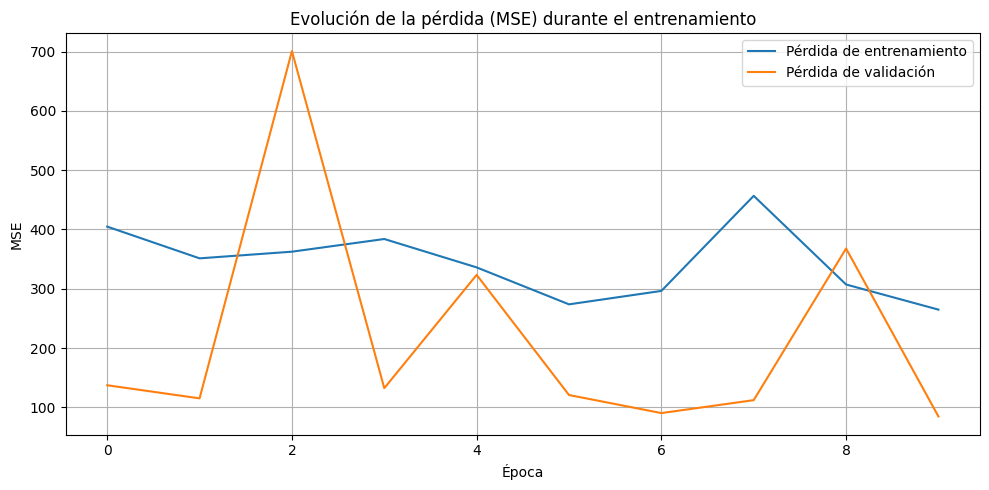

In [55]:
best_model, best_hp = optimize_lstm_univariate(
    input_data=input_data,
    output_data=output_data,
    dataindex=dataindex,
    n_back=10,
    batch_size=50,  ## si no hay tiempo, pueden bajar este parámetro
    max_trials=10,
    epochs=10,
    fast_mode=True  # Puedes cambiar a True para búsqueda completa
)

In [28]:
#Genera más inestabilidad que el modelo manual. Se debiera acirtar la ventana n_back o diferenciar la serie.

<a id="9"></a> <br>
### 8. Incrustación del modelo en la estructura de datos para pronóstico de prueba

En esta sección, vamos a embeber el modelo de la red neuronal a la estructura de datos previamente generada, en la sección de datos de prueba.

In [56]:
#
import pandas as pd
import plotly.graph_objects as go

In [57]:
#Checamos las fechas de cada segmento (ok)
print(f"Fecha de inicio en el test: {date_test_adj[0]}")
print(f"Fecha de fin en el test:   {date_test_adj[-1]}")
print(f"Rango completo de fechas: {dataindex[0]} → {dataindex[-1]}")


NameError: name 'date_test_adj' is not defined

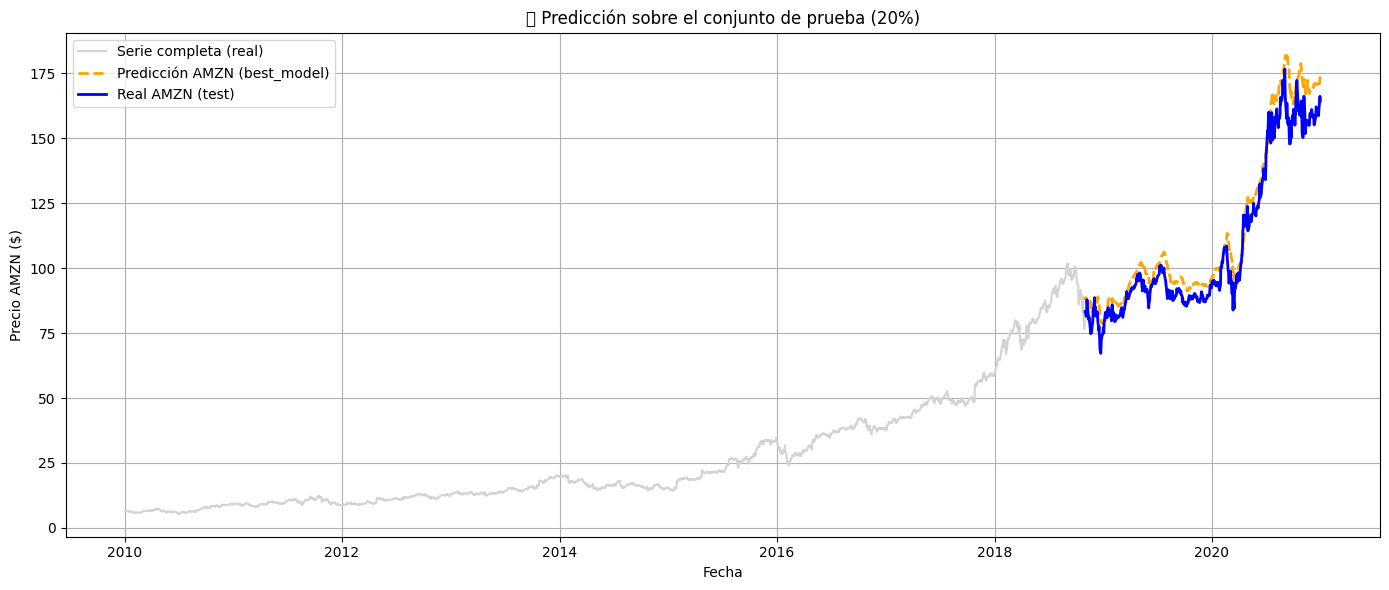

In [106]:
plt.figure(figsize=(14, 6))

# 1. Serie original (entera, en gris)
plt.plot(dataindex, output_data, label='Serie completa (real)', color='lightgray')

# 2. Predicción en el test
plt.plot(date_test_adj, prediction, label='Predicción AMZN (best_model)', linestyle='--', color='orange', linewidth=2)

# 3. Valores reales del test
plt.plot(date_test_adj, y_true, label='Real AMZN (test)', color='blue', linewidth=2)

plt.title('📈 Predicción sobre el conjunto de prueba (20%)')
plt.xlabel('Fecha')
plt.ylabel('Precio AMZN ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


<a id="10"></a> <br>
### 9. Generación del pronóstico hacia adelante

En esta sección, ya teniendo la serie entrenada con la red neuronal, aplicamos el modelo a la ventana histórica indicada equivalente para generar el pronóstico futuro.

In [58]:
close_data = dt2.reshape(-1)  # <--- esto es clave, si no, el pronóstico queda achatado, en otras dimensiones que le dió el reshape.

In [60]:
## 1 Función que contrue el modelo más óptimo
import numpy as np

def build_model(hp):
    model = Sequential()
    units = hp.get('units')
    dropout_rate = hp.get('dropout')
    model.add(LSTM(units, activation='relu', return_sequences=True, input_shape=(n_back, 1)))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units // 2, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))  # univariado
    optimizer_name = hp.get('optimizer')
    optimizer = Adam() if optimizer_name == 'adam' else RMSprop()
    model.compile(optimizer=optimizer, loss='mse')
    return model

#2 Recontrumimos el modelo con best_hiperparámetros:
# Reconstruir el modelo optimizado ---
rebuilt_model = build_model(best_hp)
rebuilt_model.set_weights(best_model.get_weights())
_ = rebuilt_model.predict(np.zeros((1, n_back, 1), dtype=np.float32))  # fijar forma


# 3] Asegurar que close_data esté en 1D ---
close_data = dt2.reshape(-1)  # ¡aquí va lo que preguntaste!

# 4] Definir predict() ---
def predict(num_prediction, model):
    prediction_list = close_data[-n_back:]
    for _ in range(num_prediction):
        x = prediction_list[-n_back:]
        x = x.reshape((1, n_back, 1)).astype(np.float32)
        out = model.predict(x, verbose=0)[0][0]
        prediction_list = np.append(prediction_list, out)
    return prediction_list[n_back-1:]

# --- [5] Generar forecast y graficar ---
forecast = predict(10, rebuilt_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


In [61]:
def predict_dates(num_prediction):
    last_date = dataindex[-1]
    return pd.date_range(start=last_date + pd.Timedelta(days=1), periods=num_prediction)


In [62]:
forecast_dates = predict_dates(10)


In [63]:
#Fechas, 10 días pegado al histórico:
def predict(num_prediction, model):
    prediction_list = close_data[-n_back:]

    for _ in range(num_prediction):
        x = prediction_list[-n_back:]
        x = x.reshape((1, n_back, 1)).astype(np.float32)
        out = model.predict(x, verbose=0)[0][0]
        prediction_list = np.append(prediction_list, out)

    return prediction_list[n_back-1:]  # solo forecast (sin la parte usada como entrada)

num_prediction = 10
forecast = predict(num_prediction, rebuilt_model)

#FEchas para el forecast:
last_date = dataindex[-1]
forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=num_prediction)


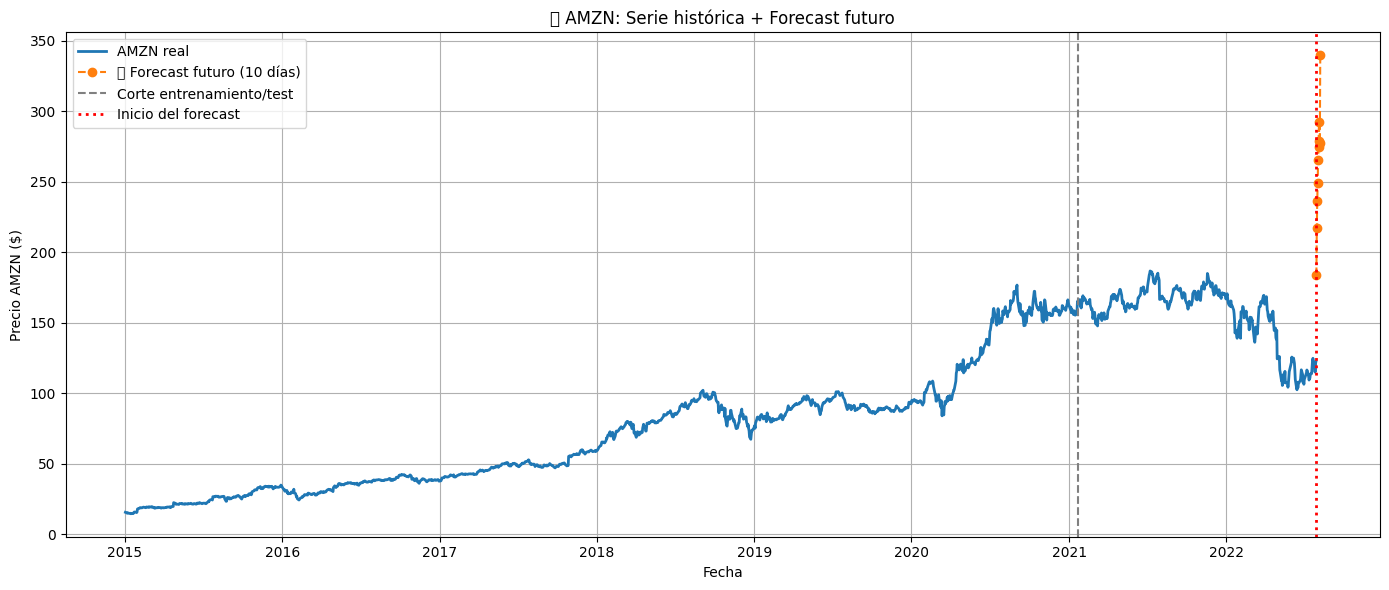

In [64]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 🔧 Fecha de corte (80%)
split = int(0.8 * len(close_data))

# Asegurar que `forecast` tenga la longitud correcta (10 en este caso)
forecast = forecast[-10:]  # Ajustar la longitud de forecast

# Gráfico
plt.figure(figsize=(14, 6))

# 1. Serie histórica
plt.plot(dataindex, close_data, label='AMZN real', linewidth=2)

# 2. Forecast futuro
plt.plot(forecast_dates, forecast, label='🔮 Forecast futuro (10 días)', linestyle='--', marker='o')

# 3. Línea vertical: corte entre entrenamiento y test
plt.axvline(x=dataindex[split], color='gray', linestyle='--', linewidth=1.5, label='Corte entrenamiento/test')

# 4. Línea vertical: inicio del forecast (último día conocido)
plt.axvline(x=dataindex[-1], color='red', linestyle=':', linewidth=2, label='Inicio del forecast')

# 🧼 Estética
plt.title('📈 AMZN: Serie histórica + Forecast futuro')
plt.xlabel('Fecha')
plt.ylabel('Precio AMZN ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

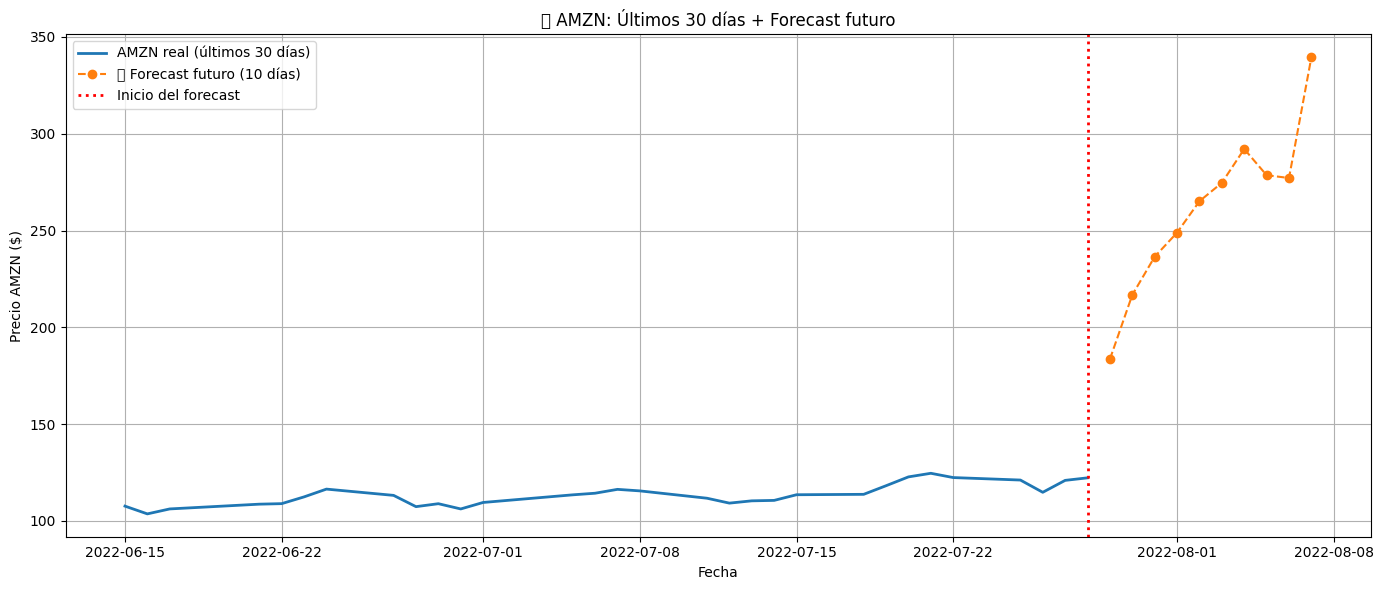

In [65]:
#ZOOM:import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Últimos 30 días históricos
n_recent = 30
recent_dates = dataindex[-n_recent:]
recent_values = close_data[-n_recent:]

# Asegurar forecast tenga longitud 10
forecast = forecast[-10:]  # por si tiene más
forecast_dates = forecast_dates[:10]  # asegurar que coincide

# Gráfico
plt.figure(figsize=(14, 6))

# 1. Últimos 30 días reales
plt.plot(recent_dates, recent_values, label='AMZN real (últimos 30 días)', linewidth=2)

# 2. Forecast futuro
plt.plot(forecast_dates, forecast, label='🔮 Forecast futuro (10 días)', linestyle='--', marker='o')

# 3. Línea vertical: inicio del forecast
plt.axvline(x=dataindex[-1], color='red', linestyle=':', linewidth=2, label='Inicio del forecast')

# Estética
plt.title('📈 AMZN: Últimos 30 días + Forecast futuro')
plt.xlabel('Fecha')
plt.ylabel('Precio AMZN ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


REsulados par ael modelo inicial. Manual

In [66]:
## Los siguientes es por si emplean la función manual.

In [67]:
close_data = dt2.reshape(-1)  # <--- esto es clave, si no, el pronóstico queda achatado, en otras dimensiones que le dió el reshape.

In [68]:
##Identificamos la posición del último valor de la serie.
dataindex[2767]

IndexError: index 2767 is out of bounds for axis 0 with size 1906

In [69]:
##Forecasting: Generamos el pronóstico hacia adelante acorde el modelo entrenado, a partir de la última fecha.
#en este caso generaremos 10 observaciones futuras y finalmente anexaremos las fechas correspondientes.
def predict_dates(num_prediction):
    last_date = dataindex[-1]
    return pd.date_range(start=last_date + pd.Timedelta(days=1), periods=num_prediction)

forecast_model_original = predict(10, model)
#forecast_model_original_rescaled = forecast_model_original * np.max(close_data)



In [70]:
#Podemos observar las fechas hacia adelante.
forecast_dates

DatetimeIndex(['2022-07-29', '2022-07-30', '2022-07-31', '2022-08-01',
               '2022-08-02', '2022-08-03', '2022-08-04', '2022-08-05',
               '2022-08-06', '2022-08-07'],
              dtype='datetime64[ns]', freq='D')

In [71]:
#Los valores del pronóstico
forecast_model_original

array([122.27999878, 120.467659  , 120.97225189, 121.75532532,
       122.61491394, 123.38526917, 123.96251678, 124.49121094,
       124.89523315, 125.23951721, 125.36179352])

<a id="11"></a> <br>
### 10. Visualización del pronóstico hacia adelante

COmo paso final, podemos generar una visuzlización de la serie, tanto de las secciones de entrenamiento, prueba y el pronóstico hacia adelante.

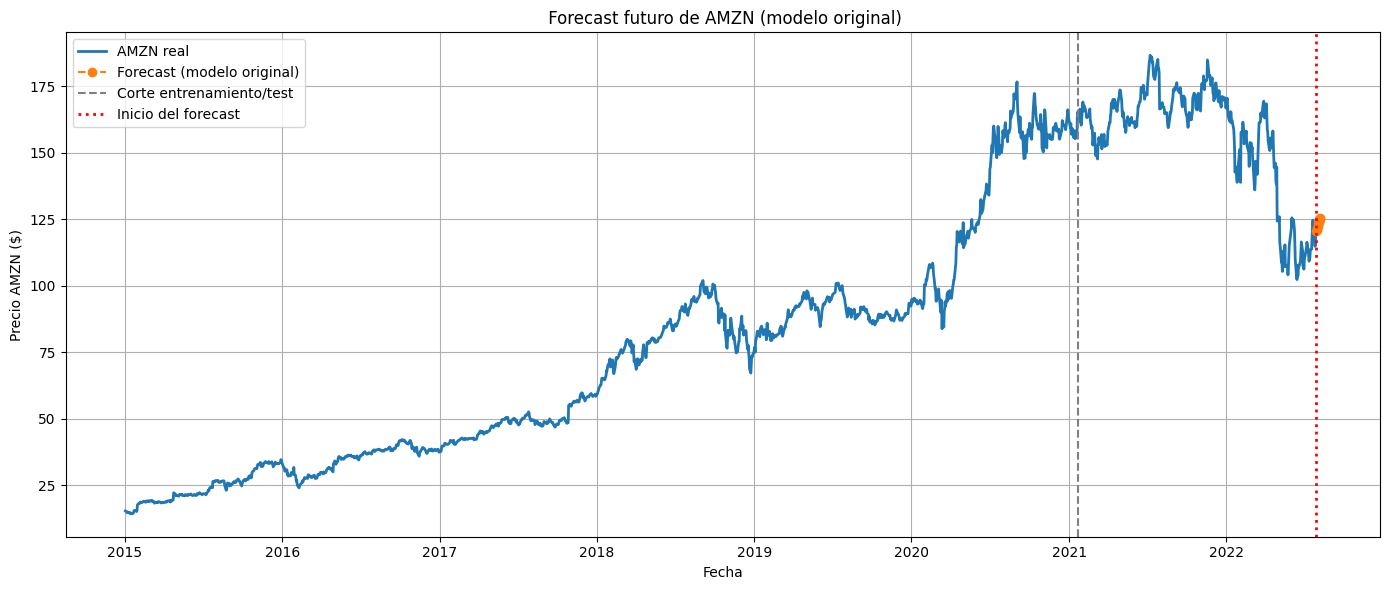

In [72]:
plt.figure(figsize=(14, 6))

# Serie histórica real
plt.plot(dataindex, close_data, label='AMZN real', linewidth=2)

# Forecast rescalado del modelo original
plt.plot(forecast_dates, forecast_model_original[-10:],
         label='Forecast (modelo original)', linestyle='--', marker='o')

# Línea de corte entrenamiento/test
plt.axvline(x=dataindex[split], color='gray', linestyle='--', linewidth=1.5, label='Corte entrenamiento/test')

# Línea de inicio del forecast
plt.axvline(x=dataindex[-1], color='red', linestyle=':', linewidth=2, label='Inicio del forecast')

plt.title(' Forecast futuro de AMZN (modelo original)')
plt.xlabel('Fecha')
plt.ylabel('Precio AMZN ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



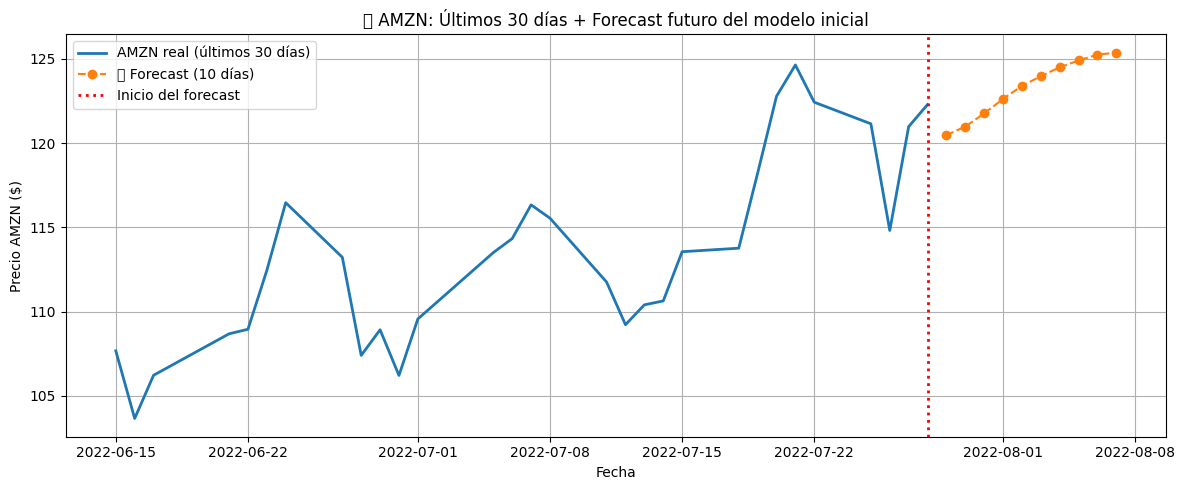

In [73]:
# Últimos 30 días reales
n_recent = 30
recent_dates = dataindex[-n_recent:]
recent_values = close_data[-n_recent:]

# Unimos con forecast
all_dates = np.concatenate([recent_dates, forecast_dates])
all_values = np.concatenate([recent_values, forecast_model_original])
plt.figure(figsize=(12, 5))

plt.plot(recent_dates, recent_values, label='AMZN real (últimos 30 días)', linewidth=2)
plt.plot(forecast_dates, forecast_model_original[-10:], label='🔮 Forecast (10 días)', linestyle='--', marker='o')

plt.axvline(x=dataindex[-1], color='red', linestyle=':', linewidth=2, label='Inicio del forecast')

plt.title('📈 AMZN: Últimos 30 días + Forecast futuro del modelo inicial')
plt.xlabel('Fecha')
plt.ylabel('Precio AMZN ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


En este tutorial aprendiste la importancia de transformar los datos de una serie de tiempo en una estructura de datos que permiten generar secuencias de entrenamiento y pronóstico de la serie con base en datos históricos. Este proceso se debe hacer especialmente cuando deseamos generar un pronóstico hacia adelante en series de tiempo. Dicho proceso es muy similar al que se emplea cuando aplicamos un problema supervisado tal como una regresión lineal, donde se generan los retrasos o lags de la serie y cuyos features ingresan al modelo de regresión. En este caso, se crea una estructura en la cual se puede emplear para entrenar una red neuronal cuyo proceso pouede ser tedioso, para ello la función de timeseriesGenerator de Keras facilita el proceso.

Ref: https://towardsdatascience.com/time-series-forecasting-with-recurrent-neural-networks-74674e289816